In [2]:
import numpy as np
import gensim
import pandas as pd
import seaborn as sns
import ast
import re
import matplotlib.pyplot as plt
from neurotools.language.simple_tokenizer import SimpleTokenizer
%matplotlib inline

From the last notebook, we observed that **cool** and **uncool** (and same as **attractive** and **unattractive**) appear on the same side of the correlations.

Looking at the Polish tokenizer, I noticed that the tokenizer actually removes the '**nie**' prefix, which signifies a negation. This is what causes the issue in the previous paragraph, since this causes the dimensions to have almost the same vector representation (we will see this in Section 2). 

However, when I plugged words with 'nie' into the Polish embedding model, I noticed that it was not in the vocabulary. As a fix, we can remove from our dimensions and from the FB posts words that have '**nie**'.

# Volkswagen Social Media Success #3

## Plan
1. Do the same tasks as in Notebook 2, but ignore words that start with **nie**.
3. Get correlations between these defined features and the success metric.

## Notebook Contents
1. Load the tokenizer, embedding and data files
2. Define features based on token list
3. Correlations with dimensions
4. Conclusion

# Load the tokenizer, embedding and data files

In [3]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [4]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


In [5]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [320]:
dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'de_label', 'pl', 'en']]
dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
dimensions['pl_with_nie'] = dimensions['pl'].map(tokenizer.tokenize)
dimensions['dimension_with_nie'] = dimensions['pl_with_nie'].map(lambda x: get_average_vector(x, emb))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [328]:
dimensions['pl_no_nie'] = dimensions['pl'].map(lambda words: tokenizer.tokenize(' '.join([word for word in words.split() if not word.startswith('nie')])))
dimensions['dimension'] = dimensions['pl_no_nie'].map(lambda x: get_average_vector(x, emb))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [325]:
simp = pd.read_csv('data/simplified_data.csv')
simp['Post_text'] = simp['Post_text'].map(ast.literal_eval)

In [326]:
# remove tokens starting with nie
simp['Post_text'] = simp['Post_text'].map(lambda words: [word for word in words if not word.startswith('nie')])

In [122]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

# Dimension vector: Tokenizer + effect of nie
Here we look at the similarity of dimensions if we remove tokens with nie.

In [110]:
def get_cos_dimensions(word1, word2, with_nie = True):
    """
        Get the cosine similarity and token overlap for dimensions
        labeled word1 and word2. Optional boolean if whether to include 
        words with nie or not.
    """
    if with_nie:
        dim = 'dimension_with_nie'
        pl_col = 'pl_with_nie'
        mode = 'with nie'
    else:
        dim = 'dimension'
        pl_col = 'pl_no_nie'
        mode = 'without nie'
    pl = cosine_similarity(dimensions.loc[dimensions['en_label'] == word1, dim].iloc[0], 
                  dimensions.loc[dimensions['en_label'] == word2, dim].iloc[0])
    pl_w1 = set(dimensions.loc[dimensions['en_label'] == word1, pl_col].iloc[0])
    pl_w2 = set(dimensions.loc[dimensions['en_label'] == word2, pl_col].iloc[0])
    pl_common_words = pl_w1.intersection(pl_w2)
    print('MODE: {}'.format(mode))
    print('{} AND {}'.format(word1, word2))
    print('PL sim: {}'.format(pl))
    print('PL {} tokens: {}'.format(word1, pl_w1))
    print('PL {} tokens: {}'.format(word2, pl_w2))
    print('{} common words in PL: {}'.format(str(len(pl_common_words)), pl_common_words))

Let's look at what happens for the **attractive** and **unattractive** dimensions.

In [97]:
get_cos_dimensions('attractive', 'unattractive')

MODE: with nie
attractive AND unattractive
PL sim: 0.8675360442815847
PL attractive tokens: {'fenomenalny', 'zwracać', 'nadzwyczajny', 'interesować', 'zwykły', 'urzekającyekscytujący', 'arcyciekawy', 'pociągać', 'wspaniały', 'estetyczny', 'ciekawy', 'uwaga', 'cudny', 'olśniewać', 'ładny', 'fascynować', 'wyśmienity', 'atrakcyjny', 'przyciągać'}
PL unattractive tokens: {'odstręczać', 'odpychać', 'pociągający', 'przyjemny', 'estetyczny', 'ciekawy', 'apetyczny', 'ładny', 'odrzucać', 'atrakcyjny'}
4 common words in PL: {'atrakcyjny', 'ładny', 'estetyczny', 'ciekawy'}


There is large overlap between tokens due to the nature of the tokenizer, and the similarity is very high at 0.86.

In [98]:
get_cos_dimensions('attractive', 'unattractive', False)

MODE: without nie
attractive AND unattractive
PL sim: 0.47235877301691187
PL attractive tokens: {'fenomenalny', 'zwracać', 'nadzwyczajny', 'interesować', 'urzekającyekscytujący', 'arcyciekawy', 'pociągać', 'wspaniały', 'estetyczny', 'ciekawy', 'uwaga', 'cudny', 'olśniewać', 'ładny', 'fascynować', 'wyśmienity', 'atrakcyjny', 'przyciągać'}
PL unattractive tokens: {'odpychać', 'odstręczać', 'odrzucać'}
0 common words in PL: set()


Issue is fixed if we don't include **nie**

Same thing happens for cool and uncool. Even if the token overlap is zero, fajny is sent to uncool since 'niefajny' is part of uncool's token list.

In [99]:
get_cos_dimensions('cool', 'uncool', True)

MODE: with nie
cool AND uncool
PL sim: 0.5049333493825188
PL cool tokens: {'zrelaksowany', 'wyluzować', 'spokojny', 'odprężyć', 'wyciszyć', 'naturalny', 'super'}
PL uncool tokens: {'fajny', 'nudny', 'śmiały', 'napiąć', 'modny', 'przedwczesny', 'bezmyślny', 'sztywny', 'spiąć'}
0 common words in PL: set()


In [101]:
get_cos_dimensions('cool', 'uncool', False)

MODE: without nie
cool AND uncool
PL sim: 0.3874906006969574
PL cool tokens: {'zrelaksowany', 'wyluzować', 'spokojny', 'odprężyć', 'wyciszyć', 'naturalny', 'super'}
PL uncool tokens: {'nudny', 'napiąć', 'przedwczesny', 'bezmyślny', 'sztywny', 'spiąć'}
0 common words in PL: set()


In [108]:
get_cos_dimensions('trustworthy', 'untrustworthy', True)

MODE: with nie
trustworthy AND untrustworthy
PL sim: 0.7013699537703632
PL trustworthy tokens: {'wiarygodny', 'racjonalny', 'trafny', 'słuszny', 'przekonywać', 'zaufanie', 'godny', 'poważny', 'solidny', 'pewny', 'odpowiedzialny'}
PL untrustworthy tokens: {'wiarygodny', 'kombinatorski', 'podejrzeć', 'zaufany', 'pewny', 'jasny', 'mglisty', 'przekonujący', 'krętacki'}
2 common words in PL: {'pewny', 'wiarygodny'}


In [109]:
get_cos_dimensions('trustworthy', 'untrustworthy', False)

MODE: without nie
trustworthy AND untrustworthy
PL sim: 0.3077155232060452
PL trustworthy tokens: {'wiarygodny', 'racjonalny', 'trafny', 'słuszny', 'przekonywać', 'zaufanie', 'godny', 'poważny', 'solidny', 'pewny', 'odpowiedzialny'}
PL untrustworthy tokens: {'mglisty', 'kombinatorski', 'podejrzeć', 'krętacki'}
0 common words in PL: set()


# Define features based on token list

We define seven features for each dimension:
* **count_pos**: normalized count of words with positive similarity with dimension X
* **count_neg**: normalized count of words with negative similarity with dimension X
* **count_zero**: normalized count of words with zero similarity with dimension X
* **mean pos**: mean similarity of words with positive similarity with dimension X 
* **mean neg**: mean similarity of words with negative similarity with dimension X
* **peak pos**: max similarity of words with positive similarity with dimension X
* **peak neg**: min similarity of words with negative similarity with dimension X

![title](fig/feat_ext.png)

peak pos and peak neg are inspired by the 'peak' in the Peak-End rule, a psychological heuristic in which people judge an experience largely based on how they felt at its peak (i.e., its most intense point) https://en.wikipedia.org/wiki/Peak%E2%80%93end_rule

In [123]:
def get_similarity_with_dimension(x, emb, dim):
    counter = 0
    collect = []
    for word in x:
        try:
            collect.append(cosine_similarity(emb[word], dim))
            counter += 1
        except KeyError:
            continue
    return np.array(collect).mean()

In [330]:
def get_av_pos_neg_similarity_with_dimension(x, emb, dim, with_neg = False):
    """
        Define features for token list x based on dimension dim
        
        Input:
            x : list of tokens
            emb : embedding model
            dim : average word vector of dimension
            with_neg : whether to include negative features
    """
    pos = []
    neg = []
    zero = []
    for word in x:
        try:
            sim = cosine_similarity(emb[word], dim)
            if sim > 0:
                pos.append(sim)
            elif sim < 0:
                neg.append(sim)
            else:
                zero.append(sim)
        except KeyError:
            continue
            
    total = 1.0 * len(pos + neg + zero)
    
    if len(pos) == 0:
        count_pos = np.nan
        mean_pos = np.nan
        peak_pos = np.nan
    else:
        count_pos = len(pos)/total
        mean_pos = np.array(pos).mean()
        peak_pos = max(pos)

    if len(neg) == 0:
        count_neg = np.nan
        mean_neg = np.nan
        peak_neg = np.nan
    else:
        count_neg = len(neg)/total
        mean_neg = np.array(neg).mean()
        peak_neg = min(neg)

    if len(zero) == 0:
        count_zero = np.nan
    else:
        count_zero = len(zero)/total
    
    if with_neg:
        return count_pos, mean_pos, peak_pos, count_neg, mean_neg, peak_neg, count_zero
    else:
        return count_pos, mean_pos, peak_pos, count_zero

In [321]:
def fix_labels(x):
    if not pd.isnull(x['en_label']):
        label = x['en_label']
    else:
        label = x['de_label']#re.sub(r'[^a-z]', '', x['en'].split()[0].lower()) + '_nan'
    return label

In [331]:
labels = dimensions.apply(fix_labels, axis=1).values

In [332]:
dimensions['fixed_label'] = dimensions.apply(fix_labels, axis=1)

Run following code block if you want to get negative features as well

In [283]:
# # define features across all posts for every dimension
# for i in range(dimensions.shape[0]):
#     simp['dim_{}'.format(labels[i])] = simp['Post_text'].map(lambda x: get_av_pos_neg_similarity_with_dimension(x, emb, dimensions['dimension'].iloc[i], True))
#     simp[['count_pos_{}'.format(labels[i]), 
#           'mean_pos_{}'.format(labels[i]), 
#           'peak_pos_{}'.format(labels[i]), 
#           'count_neg_{}'.format(labels[i]), 
#           'mean_neg_{}'.format(labels[i]), 
#           'peak_neg_{}'.format(labels[i]),
#           'count_zero_{}'.format(labels[i])]] = pd.DataFrame(simp['dim_{}'.format(labels[i])].values.tolist())

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [333]:
# define features across all posts for every dimension
for i in range(dimensions.shape[0]):
    simp['dim_{}'.format(labels[i])] = simp['Post_text'].map(lambda x: get_av_pos_neg_similarity_with_dimension(x, emb, dimensions['dimension'].iloc[i]))
    simp[['count_pos_{}'.format(labels[i]), 
          'mean_pos_{}'.format(labels[i]), 
          'peak_pos_{}'.format(labels[i]), 
          'count_zero_{}'.format(labels[i])]] = pd.DataFrame(simp['dim_{}'.format(labels[i])].values.tolist())

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [ ]:
# simp = simp[[x for x in simp.columns if not x.startswith('dim_')]]

In [334]:
simp.head()

,Post_text,success,dim_above,count_pos_above,mean_pos_above,peak_pos_above,count_zero_above,dim_african_names,count_pos_african_names,mean_pos_african_names,...,dim_pleasant_2,count_pos_pleasant_2,mean_pos_pleasant_2,peak_pos_pleasant_2,count_zero_pleasant_2,dim_volkswagen,count_pos_volkswagen,mean_pos_volkswagen,peak_pos_volkswagen,count_zero_volkswagen
0,"[witać, wiek, rok, dzisiejszy, dzień, tylko, w...",3.625,"(0.88, 0.172996332745388, 0.30350684161711794,...",0.880000,0.172996,0.303507,NaN,"(0.24, 0.04920593678265614, 0.1473961276569196...",0.240000,0.049206,...,"(0.92, 0.1561258318854441, 0.4116720395526319,...",0.920000,0.156126,0.411672,NaN,"(0.32, 0.06862705366754689, 0.1371237120764148...",0.320000,0.068627,0.137124,NaN
1,"[dakar, the, ultimate, rally, raca, oficjalnie...",4.500,"(0.45454545454545453, 0.15974476656676279, 0.3...",0.454545,0.159745,0.320306,NaN,"(0.6363636363636364, 0.10776146307696395, 0.15...",0.636364,0.107761,...,"(0.36363636363636365, 0.21812913597550054, 0.3...",0.363636,0.218129,0.314394,NaN,"(0.45454545454545453, 0.13499298771296178, 0.1...",0.454545,0.134993,0.197607,NaN
2,"[up, deklasować, konkurencja, zajrzeć, najnows...",15.125,"(0.8518518518518519, 0.11519294988809016, 0.35...",0.851852,0.115193,0.350845,NaN,"(0.2962962962962963, 0.05597805166012568, 0.11...",0.296296,0.055978,...,"(0.7407407407407407, 0.1842246168852221, 0.380...",0.740741,0.184225,0.380161,NaN,"(0.37037037037037035, 0.09174076123172507, 0.3...",0.370370,0.091741,0.395422,NaN
3,"[mały, ale, z, charakter, jaka, uważać, dodawa...",11.375,"(1.0, 0.1781907710458314, 0.2410795515781135, ...",1.000000,0.178191,0.241080,NaN,"(0.375, 0.05497281937552143, 0.100445723082544...",0.375000,0.054973,...,"(1.0, 0.21793051843371677, 0.3471882429062133,...",1.000000,0.217931,0.347188,NaN,"(nan, nan, nan, nan)",NaN,NaN,NaN,NaN
4,"[taka, czas, wiek, rok, wiek, który, wyprzedaż...",15.500,"(0.6486486486486487, 0.14944525609904968, 0.26...",0.648649,0.149445,0.269161,NaN,"(0.40540540540540543, 0.08249489248408523, 0.1...",0.405405,0.082495,...,"(0.7297297297297297, 0.14235657410599026, 0.33...",0.729730,0.142357,0.333495,NaN,"(0.4594594594594595, 0.2187361506994519, 0.967...",0.459459,0.218736,0.967951,NaN


# Correlations with dimensions

### In this notebook, we only look at associations of the form 'more X associations' (from mean pos/ peak pos). It's quite difficult to interpret 'less opposite X associations' (from mean neg/ peak neg).

In [335]:
# Look at corre
corr_matrix = simp.corr()
corr_success = corr_matrix['success']
corr_success = corr_success[~pd.isnull(corr_success)].sort_values(ascending=False)

In [336]:
upper = list(corr_success.iloc[1:26].index)
lower = list(corr_success.iloc[-25:].index)
dims_to_graph = upper + lower

In [337]:
to_bar = corr_success.loc[dims_to_graph].sort_values(ascending=True)
to_bar.index = [re.sub(r'_[0-9]+', '', x) for x in to_bar.index]

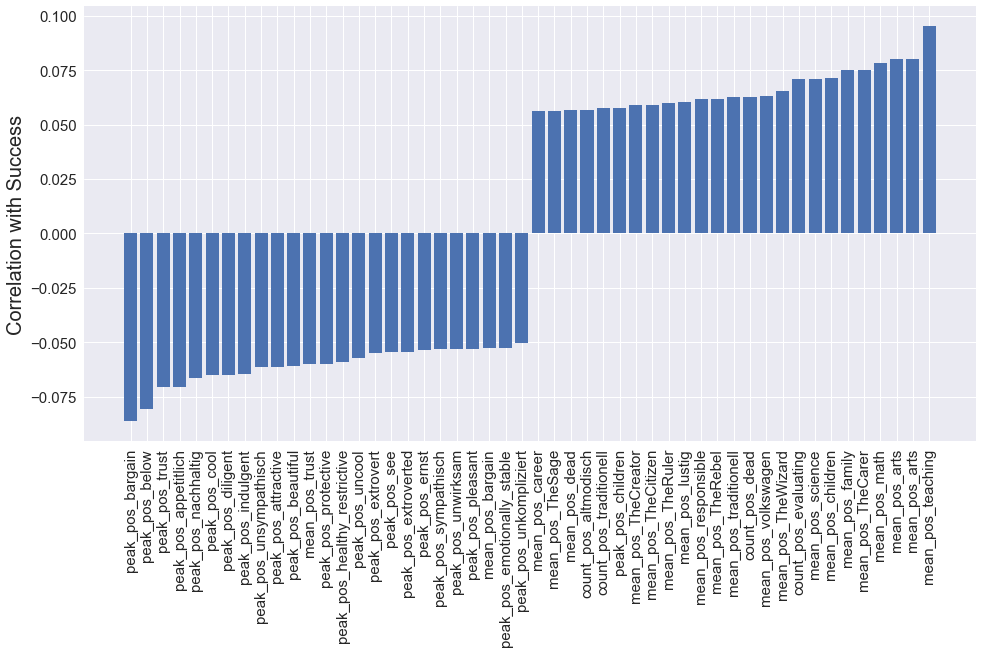

In [338]:
plt.figure(figsize=(16,8))
plt.bar(range(len(to_bar.index)), to_bar.values)
plt.xticks(range(len(to_bar.index)), to_bar.index, rotation=90, size=15);
plt.yticks(size=15);
plt.ylabel('Correlation with Success', size=20)
plt.savefig('./fig/nie_POS_bottom_top_dims_token_feats.png', bbox_inches='tight')

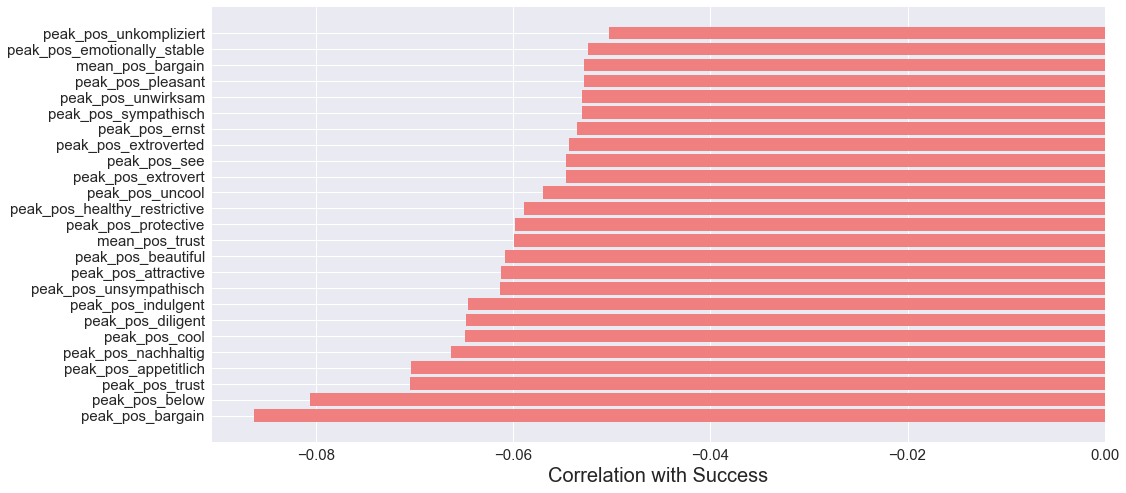

In [339]:
plt.figure(figsize=(16,8))
plt.barh(range(len(to_bar.index))[:25], to_bar.values[:25], color='lightcoral')
plt.yticks(range(len(to_bar.index))[:25], to_bar.index[:25], size=15);
plt.xticks(size=15);
plt.xlabel('Correlation with Success', size=20)
plt.savefig('./fig/nie_POS_bottom_top_dims_token_feats_bot.png', bbox_inches='tight')

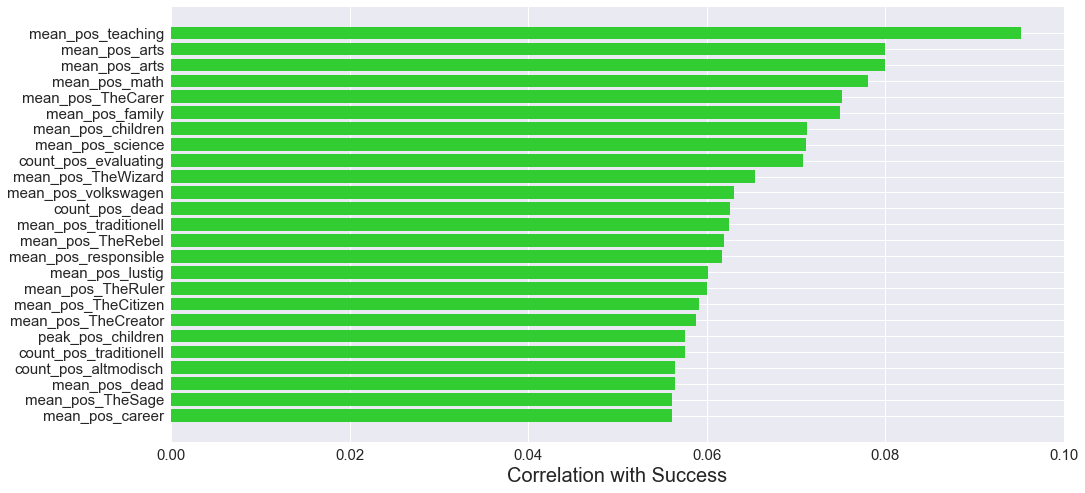

In [340]:
plt.figure(figsize=(16,8))
plt.barh(range(len(to_bar.index))[25:], to_bar.values[25:], color='limegreen')
plt.yticks(range(len(to_bar.index))[25:], to_bar.index[25:], size=15);
plt.xticks(size=15);
plt.xlabel('Correlation with Success', size=20)
plt.savefig('./fig/nie_POS_bottom_top_dims_token_feats_top.png', bbox_inches='tight')

## we label the features as 'more X associations' for easier viewing

In [341]:
def get_label(string):
    if string.find('neg') != -1:
        name = string[string.find('neg')+4:]
        label = 'less opposite {} associations'.format(name)
    elif string.find('pos') != -1:
        name = string[string.find('pos')+4:]
        label = 'more {} associations'.format(name)
    else:
        return string
    return label

In [359]:
# no_trust = [0,1,3,4,5,6,7,8,9,10]
no_trust = range(25)

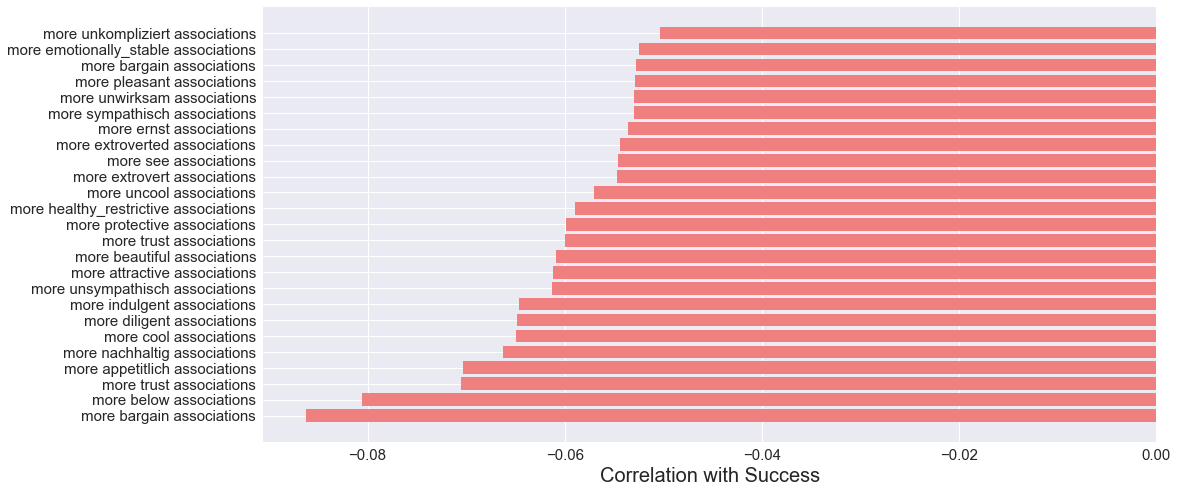

In [360]:
plt.figure(figsize=(16,8))
plt.barh(range(25), np.array(to_bar.values)[no_trust], color='lightcoral')
plt.yticks(range(25), [get_label(x) for x in np.array(to_bar.index)[no_trust]], size=15);
plt.xticks(size=15);
plt.xlabel('Correlation with Success', size=20)
plt.savefig('./fig/nie_POS_bottom_top_dims_token_feats_bot_labeled.png', bbox_inches='tight')

**Negative**: bargain, below, appetitlich, nachhaltig

It's unexpected to see cool, beautiful, attractive, diligent here since these are positive qualities.

In [356]:
#once_arts = list(range(39, 48)) + [49]
once_arts = range(25,50)

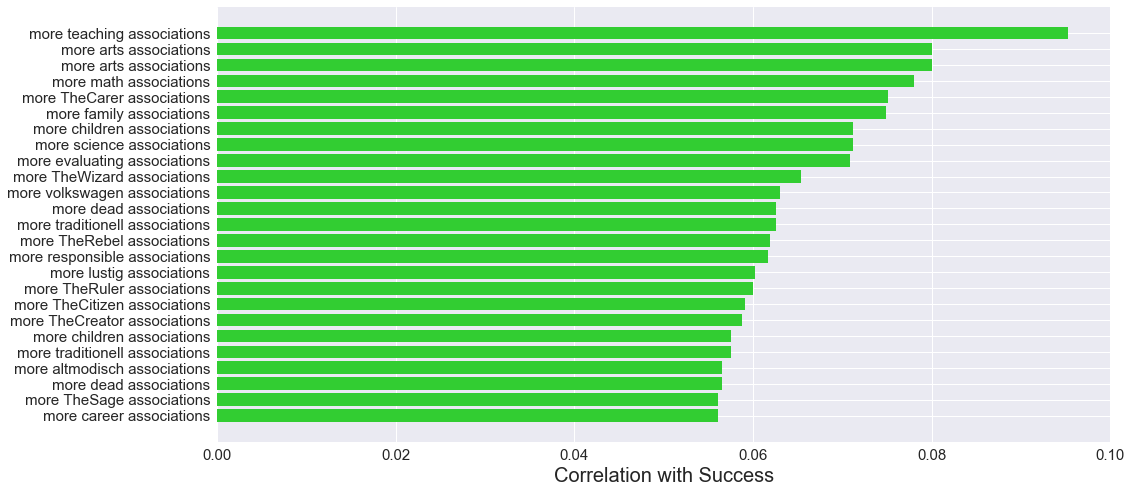

In [358]:
plt.figure(figsize=(16,8))
plt.barh(range(25), to_bar.values[once_arts], color='limegreen')
plt.yticks(range(25), [get_label(x) for x in to_bar.index[once_arts]], size=15);
plt.xticks(size=15);
plt.xlabel('Correlation with Success', size=20)
plt.savefig('./fig/nie_POS_bottom_top_dims_token_feats_top_labeled.png', bbox_inches='tight')

**Positive**: teaching, arts, math, family

In [348]:
matrix_cols = ['success'] + dims_to_graph
correlogram = corr_matrix.loc[matrix_cols, matrix_cols]

In [349]:
# correlogram.index = [get_label(x) for x in correlogram.index]
# correlogram.columns = [get_label(x) for x in correlogram.columns]

In [350]:
correlogram.to_csv('data/nie_POS_correlogram.csv', index=False)

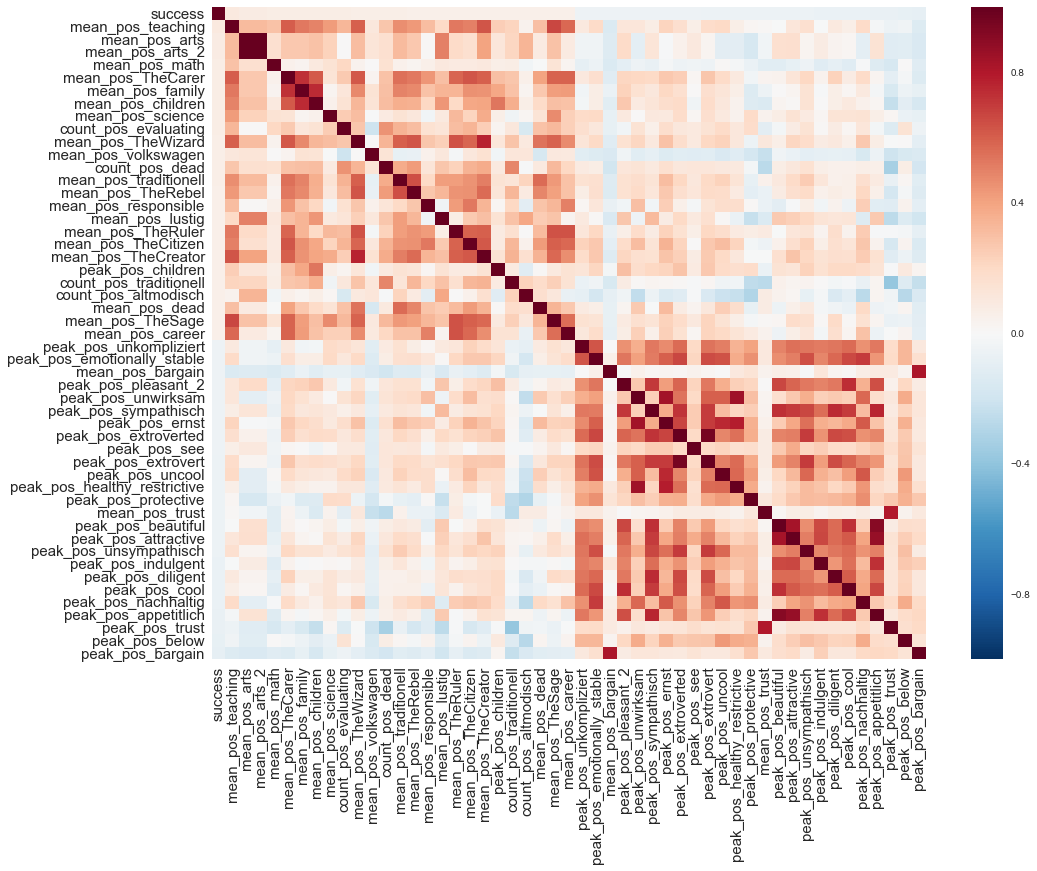

In [351]:
plt.figure(figsize=(16,12))
sns.heatmap(correlogram)
plt.xticks(size=15, rotation = 90);
plt.yticks(size=15, rotation = 0);
plt.savefig('./fig/nie_POS_corre_token_feats.png', bbox_inches='tight')

In [352]:
correlogram.index = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.index]
correlogram.columns = [get_label(re.sub(r'_[0-9]+', '', x)) for x in correlogram.columns]
correlogram.to_csv('data/nie_POS_correlogram_labeled.csv', index=False)

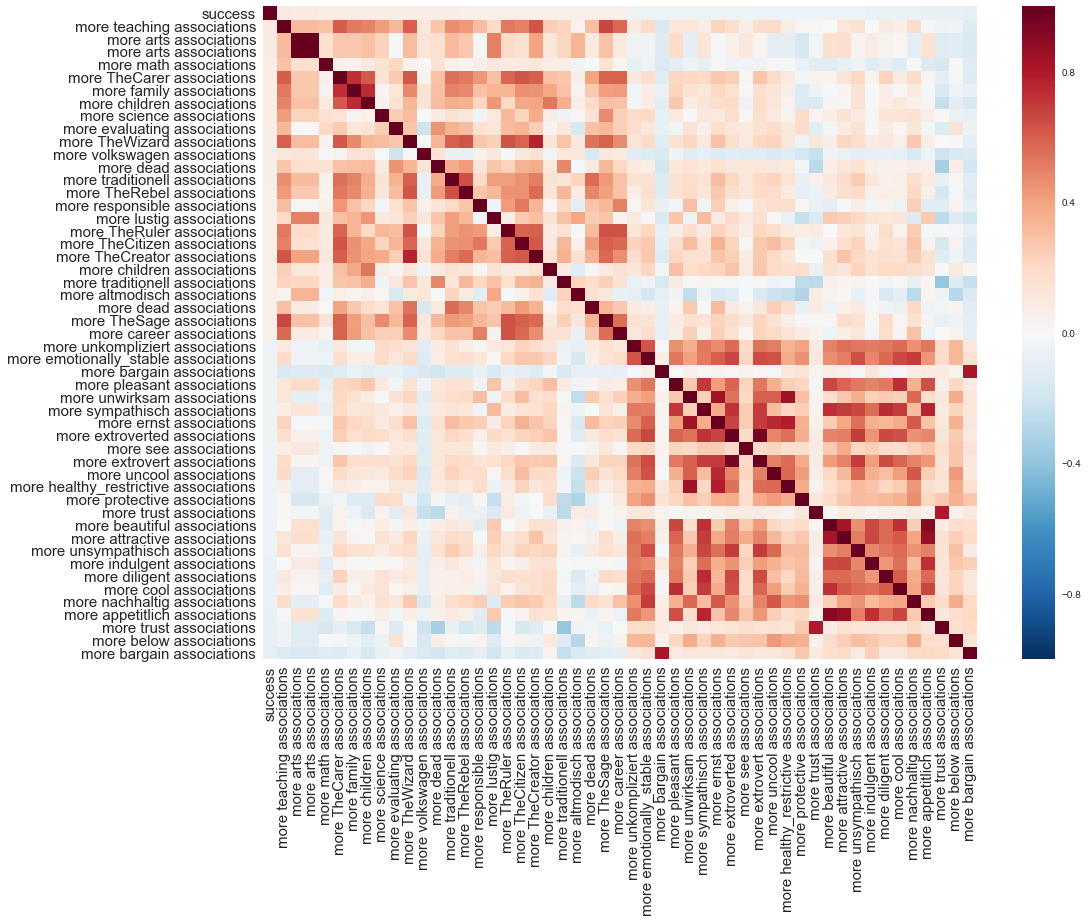

In [353]:
plt.figure(figsize=(16,12))
sns.heatmap(correlogram)
plt.xticks(size=15, rotation = 90);
plt.yticks(size=15, rotation = 0);
plt.savefig('./fig/nie_POS_corre_token_feats_labeled.png', bbox_inches='tight')

# Conclusion
We saw positive correlations with the teaching, arts, math, family dimensions and negative dimensions with bargain, below, appetitlich, nachhaltig.

*To do:*
* apply the same analysis to the other car brands
* try to make word distributions similar to the ones done in the presentation Jonathan sent, but I haven’t figured out how to do that yet. Maybe I could focus on bargain, below, teaching and arts.
* look at the papers Jonathan sent